In [2]:
import os
import gpt_functions
import json
import pandas as pd
import seaborn as sns
import json
import pickle
import openai
from bs4 import BeautifulSoup, NavigableString

In [3]:
json_schema = """{ "is_political": "int (1,0)", "reasoning": "string"}"""

In [4]:
def make_prompt(text):
   return """Below is a review of a movie. Please read the review and determine whether it is politically motivated (score = 1) or not (score = 0). \n""" + text

In [5]:
df = pd.read_csv("captain_marvel_sample.csv")

In [10]:
is_political = []
reasoning = []
for i, row in df.iterrows():
    prompt = make_prompt(row["review"])
    response = gpt_functions.ask_GPT_JSON(prompt, json_schema)
    print(response)
    response = json.loads(response)
    is_political.append(response["is_political"])
    reasoning.append(response["reasoning"])

{"is_political": "0", "reasoning": "The review appears to focus on the subjective entertainment value and quality of the film, including acting, humor, pacing, action scenes, and dramatic moments. There is no specific mention of political themes, ideologies, or political context influencing the opinion expressed."}
{
  "is_political": "1",
  "reasoning": "The review suggests a political motivation by touching on themes of gender empowerment and a perceived bias against men, which are often considered political issues. The use of terms like 'empowered woman', 'bashing men', and 'fake news' indicate the reviewer is incorporating political or ideological perspectives into their assessment of the movie."
}
{
  "is_political": "0",
  "reasoning": "The review presents a personal opinion on a movie based on its perceived plot quality and action scenes, without any clear reference to political topics or motivations."
}
{
  "is_political": "0",
  "reasoning": "The review focuses on the movie's 

In [11]:
df['is_political'] = is_political

In [15]:
df.to_csv("captain_marvel_sample_labeled.csv", index=False)

In [16]:
df['is_political'].value_counts()

0    1875
1     125
Name: is_political, dtype: int64

In [1]:
df.is_political.sum()

NameError: name 'df' is not defined

<Axes: xlabel='score', ylabel='Percent'>

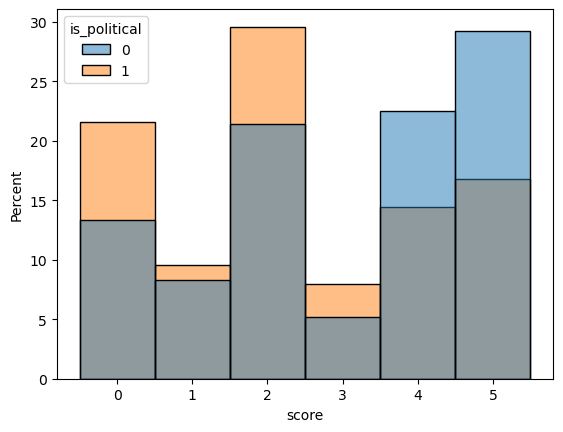

In [26]:
sns.histplot(data = df, x="score", hue="is_political", discrete=True, stat="percent", common_norm=False)

In [81]:
to_make_html = df.iloc[:50, :]

In [118]:
to_make_html['review'][49]

'The quality of Marvel films continues to improve! Captain Marvel was a better film than Wonder Woman and on par with Ironman 1 and Winter Soldier.'

In [124]:
audit_scores=[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,0, 0, 1, 1, 0,0, 0, 0, 0,0,  0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [125]:
to_make_html['audit_scores'] = audit_scores

C:\Users\v-kirdwivedi\AppData\Local\Temp\ipykernel_34992\1220141223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_make_html['audit_scores'] = audit_scores


In [128]:
pd.crosstab(to_make_html['is_political'], to_make_html['audit_scores']).to_latex('crosstab.tex')

C:\Users\v-kirdwivedi\AppData\Local\Temp\ipykernel_34992\3932744595.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.crosstab(to_make_html['is_political'], to_make_html['audit_scores']).to_latex('crosstab.tex')


In [57]:
to_make_html = to_make_html.iloc[:,[2, 3, 4]]

In [58]:
to_make_html['audit_score'] = "select"

In [61]:
to_make_html.to_html("captain_marvel_sample_labeled.html", escape=False)

In [75]:
tables = [to_make_html.to_html(escape=False)]

In [76]:
def make_tab_table(tables):
    table_soups = [BeautifulSoup(table, 'html.parser') for table in tables]

    soup = BeautifulSoup('<div></div>', 'html.parser')
    tabs_div = soup.div

    # Create the tab navigation
    nav_tabs = soup.new_tag('ul', **{'class': 'nav nav-tabs', 'role': 'tablist'})
    tabs_div.append(nav_tabs)

    # Create the tab content area
    tab_content = soup.new_tag('div', **{'class': 'tab-content'})
    tabs_div.append(tab_content)

    for index, table_soup in enumerate(table_soups, start=1):
        # Create a tab for each table
        tab_id = f'table-tab-{index}'
        nav_item = soup.new_tag('li', **{'class': 'nav-item'})
        nav_link = soup.new_tag('a', **{
            'class': 'nav-link' + (' active' if index == 1 else ''),  # Mark the first tab as active
            'id': f'{tab_id}-tab',
            'data-toggle': 'tab',
            'href': f'#{tab_id}',
            'role': 'tab',
            'aria-controls': tab_id,
            'aria-selected': 'true' if index == 1 else 'false'
        })
        nav_link.string = f'Table {index}'
        nav_item.append(nav_link)
        nav_tabs.append(nav_item)

        # Create a tab pane for each table
        tab_pane = soup.new_tag('div', **{
            'class': 'tab-pane fade' + (' show active' if index == 1 else ''),  # Mark the first pane as active
            'id': tab_id,
            'role': 'tabpanel',
            'aria-labelledby': f'{tab_id}-tab'
        })
        # Add the 'table-striped' and 'table-hover' classes to the table
        table_soup.table['class'] = table_soup.table.get('class', []) + ['table', 'table-striped', 'table-hover']
        tab_pane.append(table_soup.table)
        tab_content.append(tab_pane)


    return soup

In [79]:
def make_final_html(soup, path):
    # Parse the HTML
    tables = soup.find_all('table')

    # Create the <style> tag with your CSS
    style_tag = soup.new_tag("style")
    style_tag.string = """
    details > summary {
    cursor: pointer;
    font-weight: bold;
    }
    .hidden-content {
    display: none;
    }
    details[open] .hidden-content {
    display: block;
    }
    select {
    /* Style adjustments for the dropdown */
    padding: 5px;
    margin: 0;
    border-radius: 5px;
    }
    """

    # Add the Bootstrap CSS link
    bootstrap_link_tag = soup.new_tag('link', href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css", rel="stylesheet", integrity="sha384-QWTKZyjpPEjISv5WaRU9OFeRpok6YctnYmDr5pNlyT2bRjXh0JMhjY6hW+ALEwIH", crossorigin="anonymous")
    
    # Add jQuery and Bootstrap JS scripts
    jquery_script_tag = soup.new_tag("script", src="https://code.jquery.com/jquery-3.3.1.slim.min.js")
    jquery_script_tag.attrs['integrity'] = "sha384-q8i/X+965DzO0rT7abK41JStQIAqVgRVzpbzo5smXKp4YfRvH+8abtTE1Pi6jizo"
    jquery_script_tag.attrs['crossorigin'] = "anonymous"

    popper_script_tag = soup.new_tag("script", src="https://cdn.jsdelivr.net/npm/popper.js@1.14.7/dist/umd/popper.min.js")
    popper_script_tag.attrs['integrity'] = "sha384-UO2eT0CpHqdSJQ6hJty5KVphtPhzWj9WO1clHTMGa3JDZwrnQq4sF86dIHNDz0W1"
    popper_script_tag.attrs['crossorigin'] = "anonymous"

    bootstrap_script_tag = soup.new_tag("script", src="https://cdn.jsdelivr.net/npm/bootstrap@4.3.1/dist/js/bootstrap.min.js")
    bootstrap_script_tag.attrs['integrity'] = "sha384-JjSmVgyd0p3pXB1rRibZUAYoIIy6OrQ6VrjIEaFf/nJGzIxFDsf4x0xIM+B07jRM"
    bootstrap_script_tag.attrs['crossorigin'] = "anonymous"

    # Create the <head> tag and insert the <style> tag inside it
    head_tag = soup.new_tag("head")
    head_tag.insert(0, style_tag)
    head_tag.insert(1, bootstrap_link_tag)

    # If the document already has a <head> tag, replace it. Otherwise, insert the new <head> tag at the beginning
    existing_head = soup.head
    if existing_head:
        existing_head.replace_with(head_tag)
    else:
        soup.insert(0, head_tag)

    # Insert the scripts at the end of the body
    body_tag = soup.body
    if body_tag:
        body_tag.append(jquery_script_tag)
        body_tag.append(popper_script_tag)
        body_tag.append(bootstrap_script_tag)
    else:
        soup.append(jquery_script_tag)
        soup.append(popper_script_tag)
        soup.append(bootstrap_script_tag)

    for i, td in enumerate(soup.find_all('td', string=lambda text: text in ['select'])):
        # Clear the existing content
        k = (i + 1) % 6
        j = (i + 1) // 6

        if td.string == 'select':
            td.clear()
            dropdown_html = BeautifulSoup(f"""
        <select id="0_{j}_{k}">
        <option value="0">select</option>
        <option value="1">0</option>
        <option value="2">1</option>
        </select>
        """, 'html.parser')
            # Insert the dropdown
            td.append(dropdown_html.select_one('select'))

    # Convert back to HTML string
    edited_html_table = str(soup)
    with open(path, 'w') as f:
        f.write(edited_html_table)

In [80]:
soup = make_tab_table(tables)
make_final_html(soup, "captain_marvel_sample_labeled.html")

In [141]:
p = df['score'].mean()

In [131]:
df[df['is_political'] == 0]['score'].mean()

nan

In [142]:
p_0 = df[df['is_political'] == '0']['score'].mean()

In [143]:
import numpy as np

In [155]:
z_score = (p-p_0)/np.sqrt(np.var(df['score'], ddof=1)/len(df)+np.var(df[df['is_political'] == '0']['score'], ddof=1)/len(df[df['is_political'] == '0']))

In [161]:
import scipy.stats as stats

In [164]:
p_value = stats.norm.cdf(z_score)

In [165]:
p_value

0.22572549853400709

In [149]:
p

2.9885